In [34]:
# Import the necessary modules
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from xgboost import XGBClassifier
import matplotlib.pyplot as plt


XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ["dlopen(/Users/algh/als_code/KaggleLoanApprovalOctober24/venv/lib/python3.13/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: '@rpath/libomp.dylib'\n  Referenced from: '/Users/algh/als_code/KaggleLoanApprovalOctober24/venv/lib/python3.13/site-packages/xgboost/lib/libxgboost.dylib'\n  Reason: tried: '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/usr/lib/libomp.dylib' (no such file)"]


In [18]:
# Read train and test datasets into pandas dataframes
train_path = './data/train.csv'
test_path = './data/test.csv'
original_path = './data/credit_risk_dataset.csv'
train_df = pd.read_csv(train_path)
original_df = pd.read_csv(original_path)
test_df = pd.read_csv(test_path)

In [19]:
# Add the original dataset to the training set
train_df = pd.concat([train_df,original_df],axis=0)

In [20]:
# Check to see if there are NAs in the training and test datasets
train_df.isna().sum().sum()
test_df.isna().sum().sum()

np.int64(0)

In [21]:
# Function to plot histogram of the features and the target
def plot_histplot_for_train_df(x):
   plt.figure(figsize=(5, 3))
   sns.histplot(data=train_df, x=x)
   plt.show()

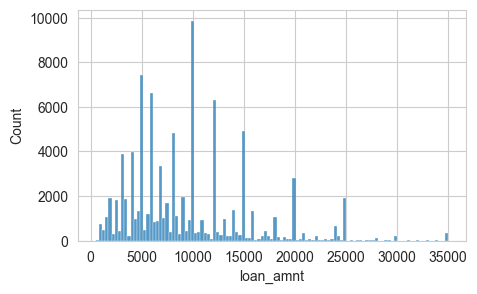

ValueError: cannot reindex on an axis with duplicate labels

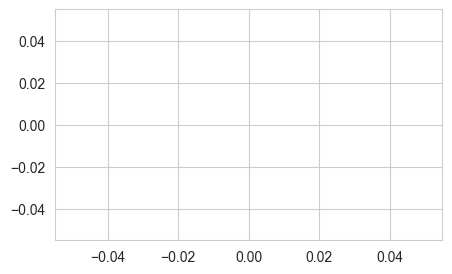

In [22]:
# Plot histogram of various columns
plot_histplot_for_train_df('loan_amnt')
plot_histplot_for_train_df('loan_int_rate')
plot_histplot_for_train_df('loan_percent_income')
plot_histplot_for_train_df('cb_person_cred_hist_length')
plot_histplot_for_train_df('cb_person_default_on_file')
plot_histplot_for_train_df('loan_grade')
plot_histplot_for_train_df('loan_intent')
plot_histplot_for_train_df('person_emp_length')
plot_histplot_for_train_df('person_home_ownership')
plot_histplot_for_train_df('person_income')
plot_histplot_for_train_df('person_age')
plot_histplot_for_train_df('loan_status')

In [23]:
# List the columns that contain NAs
null_columns = train_df.columns[train_df.isnull().any()].tolist()
print(null_columns)

['id', 'person_emp_length', 'loan_int_rate']


In [24]:
#   Replace NAs with column means
mean_value_pel = train_df['person_emp_length'].mean()
print(mean_value_pel)
train_df['person_emp_length'].fillna(mean_value_pel, inplace=True)

4.732118541807353


/var/folders/56/bh_39mb97fd0x5zggzv7g8c40000gn/T/ipykernel_59460/889202702.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['person_emp_length'].fillna(mean_value_pel, inplace=True)


In [25]:
#   Replace NAs with column means
mean_value_lir = train_df['loan_int_rate'].mean()
print(mean_value_lir)
train_df['loan_int_rate'].fillna(mean_value_lir, inplace=True)

10.789507887867437


/var/folders/56/bh_39mb97fd0x5zggzv7g8c40000gn/T/ipykernel_59460/4019073634.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['loan_int_rate'].fillna(mean_value_lir, inplace=True)


In [26]:
# create new features
train_df['TotalInt_'] = train_df["loan_amnt"]*train_df['loan_int_rate']
train_df['Income_to_Int_'] = (train_df['person_income']*12)/(train_df["loan_amnt"]*train_df['loan_int_rate'])
train_df['Income_age_'] = train_df['person_income']/train_df["person_age"]

test_df['TotalInt_'] = test_df["loan_amnt"]*test_df['loan_int_rate']
test_df['Income_to_Int_'] = (test_df['person_income']*12)/(test_df["loan_amnt"]*test_df['loan_int_rate'])
test_df['Income_age_'] = test_df['person_income']/test_df["person_age"]


In [27]:
# Remove the outliers
train_df = train_df.loc[train_df['person_emp_length']<40]
train_df = train_df.loc[train_df['person_income']<500000]
train_df = train_df.loc[train_df['person_age']<80]

In [28]:
# List of numerical features
log_num_cols = ['person_age', 'person_income',
       'person_emp_length', 'loan_amnt','loan_int_rate', 'loan_percent_income', 'TotalInt_',
       'Income_to_Int_', 'Income_age_','cb_person_cred_hist_length']

In [29]:
# Transform the numerical columns using Sklearn pipeline.  Take the log first and then apply standard scaling
from sklearn.preprocessing import FunctionTransformer

def log_transform(x):
    return np.log1p(x)

log_transformer = FunctionTransformer(log_transform)
numeric_transformer = Pipeline(
    steps=[("trans",log_transformer) , ("scaler", StandardScaler())])
preprocessor = ColumnTransformer(
    transformers=[("num", numeric_transformer, log_num_cols)])
train_df[log_num_cols] = preprocessor.fit_transform(train_df)
test_df[log_num_cols] = preprocessor.fit_transform(test_df)

In [30]:
#create train and validation sets in dataframe format
X_trf = train_df.drop(['loan_status','id'], axis=1)
y_trf = train_df['loan_status']
test_id_col = test_df[['id']]         # for future use needed to generate the final submission
X_tef = test_df.drop(['id'], axis=1)
test_id_col.head()

,id
0,58645
1,58646
2,58647
3,58648
4,58649


In [ ]:
# Encode the categorical features for both training and testing datasets.
# from category_encoders.target_encoder import TargetEncoder
# categ_cols = ['person_home_ownership','loan_intent', 'loan_grade',
#        'cb_person_cred_hist_length','cb_person_default_on_file']
# t_enc = TargetEncoder(cols=categ_cols)
# t_enc.fit(X_trf, y_trf)
# X_trf=t_enc.transform(X_trf)
# X_tef=t_enc.transform(X_tef)
# X_trf.head()

In [31]:
# Try one-hot-encoding instead of target encoding
from category_encoders import OneHotEncoder
categ_cols = ['person_home_ownership','loan_intent', 'loan_grade','cb_person_default_on_file']
t_enc = OneHotEncoder(cols=categ_cols)
t_enc.fit(X_trf, y_trf)
X_trf=t_enc.transform(X_trf)
X_tef=t_enc.transform(X_tef)
X_tef.head()

,person_age,person_income,person_home_ownership_1,person_home_ownership_2,person_home_ownership_3,person_home_ownership_4,person_emp_length,loan_intent_1,loan_intent_2,loan_intent_3,...,loan_grade_7,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file_1,cb_person_default_on_file_2,cb_person_cred_hist_length,TotalInt_,Income_to_Int_,Income_age_
0,-0.834542,0.403734,1,0,0,0,-0.116040,0,0,0,...,0,1.845821,1.483487,2.116966,1,0,-1.288389,2.225840,-1.776994,0.729709
1,-0.202259,1.129431,0,0,1,0,0.602402,0,0,1,...,0,0.412696,0.725998,-0.648285,0,1,-0.315083,0.661718,0.009457,1.169245
2,-0.202259,-1.426545,1,0,0,0,0.404501,0,0,0,...,0,-1.020288,1.788917,-0.297603,0,1,-1.288389,-0.182584,-0.718944,-1.292423
3,1.035238,-0.304034,1,0,0,0,0.170434,0,0,0,...,0,-0.145131,-0.480402,-0.182775,1,0,0.580444,-0.318696,0.089283,-0.716032
4,-0.202259,1.262653,0,0,1,0,0.925043,0,0,0,...,0,1.046853,1.606092,-0.068950,0,1,-0.315083,1.569269,-0.777295,1.297582


In [32]:
# Split the training dataset into test and validation sets
X_tr,X_va,y_tr,y_va = train_test_split(X_trf,y_trf,test_size = 0.2, shuffle=True,random_state = 23,stratify=y_trf)

In [ ]:
# correlation_matrix = train_df.corr(numeric_only=True)
# plt.figure(figsize=(20,12))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

In [ ]:
# remove redundant features
# train_df.columns
# train_df = train_df.drop('person_emp_length',axis=1)
# train_df.head()

In [ ]:
# Setting up the XGBClassifier and running a grid search to find optimal hyperparameters
# XGB = XGBClassifier(random_state=13)
# param_grid_XGB = {
#     'learning_rate': [0.05],
#     'n_estimators': [300],
#     'max_depth': [6],
#     'min_child_weight': [1],
#     'gamma': [0, 0.2],
#     'subsample': [0.5],
#     'scale_pos_weight':[4],
#     'colsample_bytree': [0.5]}
# xgb_cv = GridSearchCV(XGB, param_grid_XGB, cv=3, scoring='roc_auc', n_jobs=-1)
# xgb_cv.fit(X_tr, y_tr)
# print(xgb_cv.best_params_)
# print(xgb_cv.best_score_)

In [33]:
# Optimal parameters are plugged in the model and re-run the training.  Plot the auc metric to detect and remedy overfitting
import matplotlib.pyplot as plt
param_grid_XGB = {
    'learning_rate': 0.1,
    'n_estimators': 600,
    'max_depth': 2,
    'min_child_weight': 1,
    'gamma': 0,
    'subsample': 1.0,
    'scale_pos_weight':4,
    'colsample_bytree': 0.5,
    'verbose':False}

eval_set = [(X_tr,y_tr),(X_va,y_va)]
eval_metric = ["auc"]
xgb_final = XGBClassifier(**param_grid_XGB,eval_metric=eval_metric)
xgb_final.fit(X_tr, y_tr, eval_set=eval_set, verbose=True)

results = xgb_final.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()




NameError: name 'XGBClassifier' is not defined

In [222]:
X_tr.isna().sum().sum()

0

In [223]:
# Try Random Forest as the second model and conduct a grid search to find optimal parameters
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(random_state=13)
param_grid_RFC = {
    'max_depth': [5, 15],
    'n_estimators': [100, 200],
    'min_samples_split': [3, 10]
}
rfc_cv = GridSearchCV(RFC, param_grid_RFC, cv=3, scoring='roc_auc', n_jobs=-1)
rfc_cv.fit(X_tr, y_tr)
print(rfc_cv.best_params_)
print(rfc_cv.best_score_)

{'max_depth': 15, 'min_samples_split': 3, 'n_estimators': 200}
0.9338604448162959


In [225]:
# Plug in the optimal parameters from the gridsearch and re-run training
from sklearn.ensemble import RandomForestClassifier
eval_set = [(X_tr,y_tr),(X_va,y_va)]
eval_metric = ["auc"]
rfc_final = RandomForestClassifier(max_depth= 15, min_samples_split=3,n_estimators= 200,random_state=13)
rfc_final.fit(X_tr, y_tr)
y_pred = rfc_final.predict(X_va)

In [44]:
# Try LightGBM as the third model
'''
I was unable to install lightgbm on mac.  The code runs on colab but I just could not find a way to install it on my mac
'''
# import lightgbm as lgb
# lgbm_final = lgb.LGBMClassifier()
# lgbm_final.fit(X_tr, y_tr)
# y_pred=lgbm_final.predict(X_va)
# roc_auc_score(y_pred,y_va)
# print(y_pred[0:20])

TypeError: cpu_count() got an unexpected keyword argument 'only_physical_cores'

In [ ]:
# !pip install catboost

In [ ]:
'''
I was also unable to install catboost although I upgraded to 64-bit python.  Note that
catboost loaded and ran perfectly on Google colab.
'''
# from catboost import CatBoostClassifier
# from scipy.stats import randint, uniform
# from sklearn.model_selection import RandomizedSearchCV
# catboost_param_dist = {
#     'depth': randint(4, 10),
#     'learning_rate': uniform(0.01, 0.3),
#     'iterations': randint(10, 1000),
#     'l2_leaf_reg': randint(1, 10),
#     'border_count': randint(1, 255),
#     'bagging_temperature': uniform(0.0, 1.0),
#     'random_strength': uniform(0.0, 1.0)
# }
# # Initialize CatBoost Classifier
# CB = CatBoostClassifier()
# # Setup RandomizedSearchCV
# random_search_cb = RandomizedSearchCV(estimator=CB,
#                                       param_distributions=catboost_param_dist,
#                                       cv=5,
#                                       verbose=2,
#                                       random_state=42)
# # Fit the model
# random_search_cb.fit(X_tr, y_tr)
# # Evaluate the model
# random_search_cb_score = random_search_cb.score(X_va, y_va)
# print(random_search_cb_score)
# print(random_search_cb.best_params_)

In [ ]:
# from catboost import CatBoostClassifier
# catboost_final = CatBoostClassifier(**random_search_cb.best_params_)
# catboost_final.fit(X_tr, y_tr)
# y_pred=catboost_final.predict(X_va)
# roc_auc_score(y_pred,y_va)

In [226]:
# Voting ensemble between three models
from sklearn.ensemble import VotingClassifier
ensemble = [('RandomForest',rfc_final),('XGBoost',xgb_final)]
# ensemble = [('catboost',catboost_final),('lightGBM',lgbm_final),('RandomForest',rfc_final),('XGBoost',xgb_final)]
final_mod = VotingClassifier(estimators=ensemble,voting='soft')
final_mod = final_mod.fit(X_tr,y_tr)
y_pred = final_mod.predict_proba(X_va)
# roc_auc_score(y_pred,y_va)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:45:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [230]:
# prepare the final prediction output for submission
y_final = final_mod.predict_proba(X_tef)[:,1]
y_final_df = pd.DataFrame(y_final,columns=['loan_status'],dtype=float)
final = pd.concat([test_id_col,y_final_df],axis=1)
final.to_csv('./submission.csv', index=False)